In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import myst_nb

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [3]:
from pyperclip import copy

In [66]:
from pathlib import Path

In [92]:
def subset_cov(cov):
    return cov.drop(columns=['czname', 'stateabbrv'])

def pop_as_int(cov):
    cov.loc[:, 'pop2000'] = pd.to_numeric(cov['pop2000'].str.replace(',', ''))
    return cov

In [128]:
# Online Data Table VIII
# Commuting Zone Characteristics
cov = (pd.read_stata('onlinedata8.dta')
       .pipe(subset_cov)
       .pipe(pop_as_int)
      )
cov

,cz,pop2000,intersects_msa,cs_race_bla,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,576081,1.0,2.08e-02,...,0.19,0.11,0.60,-2.28e-03
1,200.0,227816,1.0,1.98e-02,...,0.19,0.12,0.61,-2.15e-03
2,301.0,66708,0.0,1.46e-02,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,166814,1.0,6.38e-03,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,90478,0.0,6.85e-03,...,0.24,0.12,0.60,4.91e-05
740,39400.0,3775744,1.0,4.32e-02,...,0.19,0.12,0.54,-1.55e-03


In [98]:
def subset(df):
    return (
        df[['cz', 'czname', 'stateabbrv',  'e_rank_b_8082', 's_rank_8082']]
        .rename(columns={'e_rank_b_8082': 'aum',
                         's_rank_8082': 'rm'})
    )

In [99]:
def join_cov(df):
    return df.merge(cov, on='cz')

In [129]:
# Online Data Table V
# Intergenerational Mobility Estimates by Commuting Zone
df = (pd.read_stata('onlinedata5.dta')
      .pipe(subset)
      .pipe(join_cov)
     )
df

,cz,czname,stateabbrv,aum,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,Johnson City,TN,38.39,...,0.19,0.11,0.60,-2.28e-03
1,200.0,Morristown,TN,37.78,...,0.19,0.12,0.61,-2.15e-03
2,301.0,Middlesborough,TN,39.05,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,Bellingham,WA,44.12,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,Port Angeles,WA,41.41,...,0.24,0.12,0.60,4.91e-05
740,39400.0,Seattle,WA,43.20,...,0.19,0.12,0.54,-1.55e-03


In [74]:
cov.columns

Index(['cz', 'pop2000', 'intersects_msa', 'cs_race_bla', 'cs_race_theil_2000',
       'cs00_seg_inc', 'cs00_seg_inc_pov25', 'cs00_seg_inc_aff75',
       'frac_traveltime_lt15', 'hhinc00', 'gini', 'inc_share_1perc', 'gini99',
       'frac_middleclass', 'taxrate', 'subcty_total_expenditure_pc',
       'tax_st_diff_top20', 'eitc_exposure', 'ccd_exp_tot',
       'ccd_pup_tch_ratio', 'score_r', 'dropout_r', 'num_inst_pc', 'tuition',
       'gradrate_r', 'cs_labforce', 'cs_elf_ind_man', 'd_tradeusch_pw_1990',
       'frac_worked1416', 'mig_inflow', 'mig_outflow', 'cs_born_foreign',
       'scap_ski90pcm', 'rel_tot', 'crime_violent', 'cs_fam_wkidsinglemom',
       'cs_divorced', 'cs_married', 'incgrowth0010'],
      dtype='object')

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [130]:
def get_vars(df, X=['gini'], y='aum'):
    df = df[[*X, y]].dropna()
    return df[X], df[y]

In [149]:
X, y = df.pipe(get_vars, ['cs_race_bla', 'gini'])

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [151]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, model.predict(X_test))

12.182439

In [152]:
np.sqrt(model.score(X_train, y_train))

0.653017018359914

In [154]:
model.coef_

array([-17.47, -27.16], dtype=float32)

<AxesSubplot:ylabel='resid'>

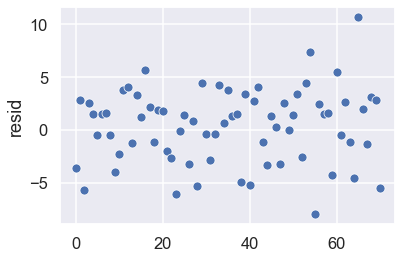

In [165]:
resid = ((pred - y_test)
         .rename('resid')
         .reset_index(drop=True)
         .to_frame()
        )
sns.scatterplot(data=resid, x=resid.index, y='resid');

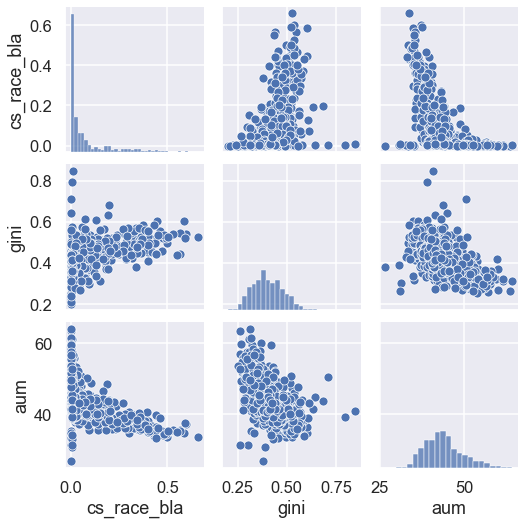

In [146]:
sns.pairplot(df[['cs_race_bla', 'gini', 'aum']]);

In [168]:
# urban areas
df['stateabbrv'].value_counts()

TX    64
KS    32
GA    28
      ..
RI     1
CT     1
DC     1
Name: stateabbrv, Length: 51, dtype: int64